# Data Loading, Cleaning & Merging

### Importazione Librerie

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests

### Caricamento Dati

In [68]:
CSV_files = {
    "customers":           r"dataset/olist_customers_dataset.csv",
    "geolocation_dataset": r"dataset/olist_geolocation_dataset.csv",
    "order_items":         r"dataset/olist_order_items_dataset.csv",
    "order_payments":      r"dataset/olist_order_payments_dataset.csv",
    "order_review":        r"dataset/olist_order_reviews_dataset.csv",
    "order_dataset":       r"dataset/olist_orders_dataset.csv",
    "list_product":        r"dataset/olist_products_dataset.csv",
    "list_seller":         r"dataset/olist_sellers_dataset.csv",
    "product_category":    r"dataset/product_category_name_translation.csv"
}

dataframes = {name: pd.read_csv(path) for name, path in CSV_files.items()}

df_customers           = dataframes["customers"]
df_orders_items        = dataframes["order_items"]
df_order_payments      = dataframes["order_payments"]
df_order_review        = dataframes["order_review"]
df_order_dataset       = dataframes["order_dataset"]
df_list_product        = dataframes["list_product"]
df_list_seller         = dataframes["list_seller"]
df_product_category    = dataframes["product_category"]
df_geolocation_dataset = dataframes["geolocation_dataset"]

### Analisi Preliminare

In [70]:
# Stampa un riepilogo di ogni csv con la sua shape e i missing values.
def quick_overview(df, name):
    print(f"{name}")
    print(f"Shape: {df.shape}")
    nulls = df.isna().sum()
    nulls = nulls[nulls > 0]
    if len(nulls) > 0:
        print(f"Valori nulli:\n{nulls.to_string()}\n")
    else:
        print("Nessun valore nullo\n")

for name, df in dataframes.items():
    quick_overview(df, name)

customers
Shape: (99441, 5)
Nessun valore nullo

geolocation_dataset
Shape: (1000163, 5)
Nessun valore nullo

order_items
Shape: (112650, 7)
Nessun valore nullo

order_payments
Shape: (103886, 5)
Nessun valore nullo

order_review
Shape: (99224, 7)
Valori nulli:
review_comment_title      87656
review_comment_message    58247

order_dataset
Shape: (99441, 8)
Valori nulli:
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965

list_product
Shape: (32951, 9)
Valori nulli:
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2

list_seller
Shape: (3095, 4)
Nessun valore nullo

product_category
Shape: (71, 2)
Nessun valore nullo



### PULIZIA: df_list_product

In [71]:
# 1) Droppiamo le colonne (peso, misure)
# 2) Droppiamo i 610 prodotti senza categoria (< 2% del totale):
#    verranno esclusi anche dagli altri df.
# 3) Uniamo la traduzione inglese della categoria.

# 1
df_list_product = df_list_product.drop(
    columns=['product_name_lenght', 'product_width_cm',
             'product_height_cm', 'product_length_cm', 'product_weight_g']
)

# 2
# Salviamo gli id dei prodotti senza categoria per filtrare order_items dopo
product_id_nan = df_list_product[df_list_product['product_category_name'].isna()]
product_id_to_delete = product_id_nan['product_id'].to_numpy()
df_list_product = df_list_product.dropna(subset=['product_category_name'])

# 3
df_list_product = (
    df_list_product
    .merge(df_product_category, on='product_category_name', how='left')
    .drop(columns=['product_category_name'])
)

df_list_product.info()
df_list_product.sample(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32341 entries, 0 to 32340
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     32341 non-null  object 
 1   product_description_lenght     32341 non-null  float64
 2   product_photos_qty             32341 non-null  float64
 3   product_category_name_english  32328 non-null  object 
dtypes: float64(2), object(2)
memory usage: 1010.8+ KB


,product_id,product_description_lenght,product_photos_qty,product_category_name_english
18545,d81d3da04eaeaf9608d87763815d7885,457.0,5.0,housewares
17469,3377b442347c19fe5f5d740892c180e6,1416.0,1.0,electronics


### PULIZIA: df_orders_items

In [72]:
# 1) Escludiamo gli items con product_id in product_id_to_delete
# 2) Convertiamo shipping_limit_date in datetime

# 1
df_orders_items = (
    df_orders_items[~df_orders_items['product_id'].isin(product_id_to_delete)]
    .copy()
    .reset_index(drop=True)
)

# 2
df_orders_items['shipping_limit_date'] = pd.to_datetime(
    df_orders_items['shipping_limit_date']
)

df_orders_items.info()
df_orders_items.sample(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111047 entries, 0 to 111046
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             111047 non-null  object        
 1   order_item_id        111047 non-null  int64         
 2   product_id           111047 non-null  object        
 3   seller_id            111047 non-null  object        
 4   shipping_limit_date  111047 non-null  datetime64[ns]
 5   price                111047 non-null  float64       
 6   freight_value        111047 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 5.9+ MB


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
19458,2d56f831faff17de02fb49d2155fb2e5,1,1b8fb2ae90018c533840a8085ca9ad6b,99002261c568a84cce14d43fcffb43ea,2018-08-02 11:24:28,100.0,23.42
10691,18b9fb35499462319a6ca38275f72810,1,3ff81cd0e0861e991bb0106c03c113ca,86bb7c4b535e49a541baf3266b1c95b1,2018-02-09 13:15:29,349.9,14.79


### PULIZIA: df_order_dataset

In [73]:
# 1) Conversione delle colonne data in datetime

# 2) delivery_delay_days : differenza tra consegna effettiva e stimata
#    (positivo = in ritardo, negativo = in anticipo)
#    actual_delivery_days: giorni totali dall'acquisto alla consegna

# 1
date_cols = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]
for col in date_cols:
    df_order_dataset[col] = pd.to_datetime(df_order_dataset[col])

# 2
df_order_dataset['delivery_delay_days'] = (
    df_order_dataset['order_delivered_customer_date'] -
    df_order_dataset['order_estimated_delivery_date']
).dt.days
df_order_dataset['actual_delivery_days'] = (
    df_order_dataset['order_delivered_customer_date'] -
    df_order_dataset['order_purchase_timestamp']
).dt.days

df_order_dataset.info()
df_order_dataset.sample(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
 8   delivery_delay_days            96476 non-null  float64       
 9   actual_delivery_days           96476 non-null  float64       
dtypes: datetime64[ns](5), float64(2), object(3)
memory usage: 7.6+ MB


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_delay_days,actual_delivery_days
58490,4fc714d903314beff16d93bd2e75f612,3f63fb49ebef23d07c3ceaf4855572d8,delivered,2018-04-17 18:41:47,2018-04-17 18:55:17,2018-04-18 19:46:24,2018-05-18 21:42:59,2018-05-24,-6.0,31.0
7372,7d76335e7e80375e28928a33bc942ebc,71faaf972f231660f00732bc7c103241,delivered,2017-06-05 11:38:20,2017-06-05 11:50:11,2017-06-08 15:26:20,2017-06-19 16:09:44,2017-06-26,-7.0,14.0


### PULIZIA: df_order_review

In [74]:
# 1) Conversione della colonna review_creation_date in datetime
# 2) Droppiamo le colonne (review_comment_title, review_comment_message)

# 1
df_order_review['review_creation_date'] = pd.to_datetime(
    df_order_review['review_creation_date']
)

# 2
df_order_review = df_order_review.drop(columns= ['review_comment_title', 'review_comment_message'])

df_order_review.sample(2)

,review_id,order_id,review_score,review_creation_date,review_answer_timestamp
48157,71da3833adeff48b17bc979fe9cc4f6d,296487514bc938361dae8cac848688ac,5,2017-05-04,2017-05-05 14:21:35
89646,fd79cc4422c1831c888d1e394c0a3db4,a3316b63c1f065d129b524f658cce198,5,2018-03-15,2018-03-16 01:15:40


### PULIZIA: df_order_payments

In [75]:
# Per un ordine ci sono diverse righe di pagamenti
# Aggreghiamo per order_id

df_order_payments = (
    df_order_payments
    .groupby('order_id', as_index=False)
    .agg(
        total_payment_value  = ('payment_value', 'sum'),
        payment_installments = ('payment_installments', 'max'),
        payment_type         = ('payment_type', 'first')
    )
)

df_order_payments.sample(10)

,order_id,total_payment_value,payment_installments,payment_type
18402,2f9892eb8df4a437d90cc5b1486f3b02,121.09,3,credit_card
99175,ff3cf519c35d0a3c371c62b507838a45,228.03,6,credit_card
87794,e1a3812afec72cd377060bfcf9dbf91e,44.02,1,credit_card
12329,1fc4c658ba7a1f8edf3492ce534944ee,76.18,1,credit_card
23145,3ba1ccc3882bd7df61ee5030f44ec1d2,194.00,5,credit_card
58953,98b1e2ab7ac5c2be52f3e1d74ce5b18e,68.02,1,debit_card
5812,0ed4f86f537498adc199e28f682e2946,61.61,6,credit_card
82539,d4156493c21d6dc99c265f66e3943122,265.40,4,credit_card
54310,8c64dfe75b003b8f1eddd9721843049a,60.42,1,credit_card
68321,b05b331d732972ead47dbea28dd5305f,64.11,1,credit_card


### PULIZIA: df_geolocation_dataset

In [76]:
# Coordinate del Brasile
brazil = {
    "lat_min": -34.0, "lat_max": 5.0,
    "lng_min": -75.0, "lng_max": -28.0
}

# Filtra coordinate fuori dal Brasile
df_geolocation_clean = df_geolocation_dataset[
    df_geolocation_dataset["geolocation_lat"].between(brazil["lat_min"], brazil["lat_max"]) &
    df_geolocation_dataset["geolocation_lng"].between(brazil["lng_min"], brazil["lng_max"])
].copy()

# Raggruppa per zip code (media lat/lng, primo valore per città e stato)
df_geolocation_dataset = (
    df_geolocation_clean
    .groupby('geolocation_zip_code_prefix', as_index=False)
    .agg(
        geolocation_lat   = ('geolocation_lat',   'mean'),
        geolocation_lng   = ('geolocation_lng',   'mean'),
        geolocation_city  = ('geolocation_city',  'first'),
        geolocation_state = ('geolocation_state', 'first')
    )
)

df_geolocation_dataset.info()
df_geolocation_dataset.sample(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19011 entries, 0 to 19010
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   geolocation_zip_code_prefix  19011 non-null  int64  
 1   geolocation_lat              19011 non-null  float64
 2   geolocation_lng              19011 non-null  float64
 3   geolocation_city             19011 non-null  object 
 4   geolocation_state            19011 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 742.7+ KB


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
11462,55515,-8.376910,-35.451892,amaraji,PE
7689,28894,-22.514343,-41.948844,rio das ostras,RJ


### PULIZIA: df_list_seller

In [77]:
df_list_seller=df_list_seller.rename(columns={'seller_zip_code_prefix':'geolocation_zip_code_prefix'})
df_list_seller.sample(3)

,seller_id,geolocation_zip_code_prefix,seller_city,seller_state
2596,0f519b0d2e5eb2227c93dd25038bfc01,14940,ibitinga,SP
2683,abc015ebac1d283a323ca9db35ede4b9,14055,ribeirao preto,SP
2400,2ea0861cc19e94cad86438c984c52da4,3731,sao paulo,SP


### PULIZIA: df_customers

In [83]:
df_customers=df_customers.rename(columns={'customer_zip_code_prefix':'geolocation_zip_code_prefix'})
df_customers.sample(3)

,customer_id,customer_unique_id,geolocation_zip_code_prefix,customer_city,customer_state
38041,02754b1e0a87a51622b4a49cdac7cadf,d3fc34ba9517a510bc470a95c0207cbc,51190,recife,PE
73137,9992dd6e05230ed6258a1e7fd24d34dc,756d6380300264d58952966c08edb1c5,22220,rio de janeiro,RJ
39817,4ad7e384a9915942c0b8bd7eb448b6b3,e1b22883de52fb6e132faa3ca7ee3b5c,14270,santa rosa de viterbo,SP


### TEST DI IPOTESI: GLI ORDINI RELATIVI A PRODOTTI CON METODI DI PAGAMENTO MULTIPLI HANNO UN MAGGIOR NUMERO DI VENDITE?

H0: Il tipo di pagamento (singolo o multiplo) non influisce sul numero di ordini acquistati.

H1: I prodotti con più metodi di pagamento hanno un numero di acquisti maggiore.

In [146]:
# Faccio una merge fra order_payments e orders_items
m_items_payments = df_order_payments.merge(df_orders_items[['order_id', 'order_item_id', 'product_id', 'price']], how = 'inner', on = 'order_id')
m_items_payments.sample(2)

,order_id,total_payment_value,payment_installments,payment_type,order_item_id,product_id,price
95476,dbc3b0665b060a97f3298ba46f58ce1b,32.70,1,credit_card,1,d4a3b5aa064bf44e74f1e71862bea22a,19.9
48083,6ed6b87e6f8afe27921e761104771bbd,137.47,1,boleto,1,3fc00af0f0a8d4ac2933d3900416c977,99.0


In [147]:
# Raggruppo per prodotto e conto i metodi di pagamento distinti
payment_counts = m_items_payments.groupby('product_id')['payment_type'].nunique().reset_index()
payment_counts.rename(columns={'payment_type':'num_payments'}, inplace=True)

# Controllo quanti ordini hanno più di 1 metodo di pagamento
(payment_counts['num_payments'] > 1).sum()

# Inserisco la colonna payment_counts nel df
m_items_payments = m_items_payments.merge(payment_counts, on='product_id', how='left')

In [148]:
# Creo una colonna che distingue i due gruppi: pagamento multiplo e pagamento singolo
payment_group_list = []  # lista vuota dove metteremo il gruppo per ogni riga

for index, row in m_items_payments.iterrows():
    if row['num_payments'] > 1:
        payment_group_list.append('multi')  # più di un metodo -> multi
    else:
        payment_group_list.append('single')  # altrimenti -> single

m_items_payments['payment_group'] = payment_group_list

print(m_items_payments[['product_id', 'num_payments', 'payment_group']].head())

                         product_id  num_payments payment_group
0  4244733e06e7ecb4970a6e2683c13e61             3         multi
1  e5f2d52b802189ee658865ca93d83a8f             1        single
2  c777355d18b72b67abbeef9df44fd0fd             1        single
3  7634da152a4610f1595efa32f14722fc             1        single
4  ac6c3623068f30de03045865e4e10089             3         multi


In [149]:
# Controllo le vendite totali per le categorie multi e single
df_total_sales = m_items_payments.groupby('payment_group')['order_item_id'].count().reset_index(name='sales_count')
print(df_total_sales)

  payment_group  sales_count
0         multi        72234
1        single        38810


In [ ]:
# Preparo il df per il permutation test
product_sales = m_items_payments.groupby(['product_id','payment_group'])['order_item_id'].count().reset_index(name='sales_count')

In [151]:
product_sales.sample(5)

,product_id,payment_group,sales_count
17162,878c61936b5c51f321ac165750d97a0b,multi,5
17815,8d027132a8818b4d661e9d83778f8bd0,single,1
28721,e3258912258da913595140fce3854b5f,single,1
16238,7fda6ff601b1c45aacfd6a24e7f2d45f,single,1
17342,891c2f4debd2ffa4848227e82c619d75,single,1


In [157]:
# Calcolo la media di sales per le categorie multi e single

mu_multi = np.mean(product_sales[product_sales.payment_group == 'multi']['sales_count'])
mu_single = np.mean(product_sales[product_sales.payment_group == 'single']['sales_count'])
mu_diff = mu_multi - mu_single
print('Test statistico osservato:', mu_diff,)
print('')

# Permutation test

n = 1000
mu_diff_samples = []
for i in range(n): 
    # extract a subsample of 50% of data without replacement
    df_sample1 = product_sales.sample(frac=0.5, replace=False)
    # use set() to get indexes of rows that were not extracted from df in previous step
    ix2 = set(product_sales.index) - set(df_sample1.index)
    # create dataframe with other 50% of data
    df_sample2 = product_sales.loc[list(ix2)]
    # calculate difference in mean from each sample
    mu_diff_temp = np.mean(df_sample1['sales_count']) - np.mean(df_sample2['sales_count'])
    # append sampled mean difference to mu_diff_samples list
    mu_diff_samples.append(mu_diff_temp)

# Calcolo il p-value

print('Results more extreme than observed:', sum([el >= mu_diff for el in mu_diff_samples]))
print('Total results:', len(mu_diff_samples))
p_value = sum([el >= mu_diff for el in mu_diff_samples])/n
print('p-value:', sum([el >= mu_diff for el in mu_diff_samples]), '/', len(mu_diff_samples), '=', p_value)
print('')
print('Response:')
# Scelgo un livello si significatività del 5%
alpha = 0.05

if p_value <= alpha: 
    print('H0 rejected: the observed result is statistically significant | p-value <= alpha')
else: 
    print('H0 accepted | the observed result is not statistically significant | p-value > alpha')

Test statistico osservato: 8.001929743249592

Results more extreme than observed: 0
Total results: 1000
p-value: 0 / 1000 = 0.0

Response:
H0 rejected: the observed result is statistically significant | p-value <= alpha


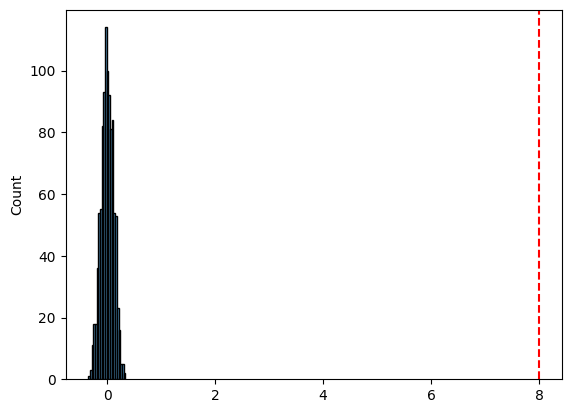

Avgerage Simulated Test Statistic: -0.0050
Initially Observed Test Statistic: 8.0019


In [158]:
sns.histplot(mu_diff_samples)
plt.axvline(mu_diff, 0, 1, color='r', linestyle='--')
plt.show()
print('Avgerage Simulated Test Statistic:', f'{np.mean(mu_diff_samples):.4f}')
print('Initially Observed Test Statistic:', f'{mu_diff:.4f}')

In [156]:
# Permutation test corretto
##questo tipo di permutazione non suddivide in maniera casuale i due gruppi, ma mantiente le categorie multi e single
n = 5000
mu_diff_samples = []

for i in range(n):
    shuffled = product_sales['payment_group'].sample(frac=1, replace=False).reset_index(drop=True)
    group_multi = product_sales.loc[shuffled=='multi','sales_count']
    group_single = product_sales.loc[shuffled=='single','sales_count']
    mu_diff_samples.append(group_multi.mean() - group_single.mean())

# p-value
p_value = sum([el >= mu_diff for el in mu_diff_samples])/n
print('p-value:', p_value)

# Decisione statistica
alpha = 0.05
if p_value <= alpha:
    print('H0 rejected: differenza significativa')
else:
    print('H0 accepted: nessuna differenza significativa')

p-value: 0.0
H0 rejected: differenza significativa
